In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn' заглушить SettingWithCopyWarning
from sklearn.metrics import r2_score as r2, mean_squared_error as mse

from sklearn.linear_model import Ridge #L2 reg
import statsmodels.api as sm #to find p-values

import torch #to save model

### Выгрузка данных

In [4]:
#датасет с соревнования 
dataset = pd.read_csv('train.zip', index_col=0, header=[0, 1])
dataset.rename(
    columns={
        'Unnamed: 209_level_1': 'count',
        'Unnamed: 210_level_1': 'price',
    },
    level = 1,
    inplace = True
)
data_competition=dataset.copy()

In [5]:
del dataset

In [6]:
data_competition['price_in_60s']=data_competition['price']['price'].shift(-60).fillna(0)
data_competition=data_competition[data_competition.price_in_60s!=0]

In [7]:
data=data_competition

In [9]:
data['bid_quantity_0']

,sum,nunique,mean,median,std,min,max,first,last
0,25880.7,5,392.131818,43.2,756.794113,5.9,1985.0,1985.0,5.9
1,76.7,1,5.900000,5.9,0.000000,5.9,5.9,5.9,5.9
2,597.5,3,39.833333,60.3,24.228515,5.9,60.3,5.9,60.3
3,2062.8,2,39.669231,30.5,13.888033,30.5,60.3,60.3,30.5
4,6350.8,2,302.419048,366.4,135.157396,30.5,366.4,30.5,366.4
...,...,...,...,...,...,...,...,...,...
1299935,2721.0,3,69.769231,61.0,22.135303,60.0,121.0,60.0,121.0
1299936,1268.0,3,84.533333,61.0,30.821761,60.0,121.0,60.0,60.0
1299937,9131.6,8,83.776147,66.3,41.644263,51.1,260.0,60.0,260.0
1299938,7819.0,5,111.700000,90.5,70.686778,51.1,260.0,260.0,109.8


## Сборка признаков

#### Таблица с используемыми признаками:
(Benchmark Dataset for Mid-Price Forecasting of Limit Order Book Data with Machine Learning Methods)

пока реализованы $u_{1},u_{2},u_{3},u_{4}$

![title](features.png)

Basic

In [7]:
#5 levels LOB
U1=pd.DataFrame()
for i in range(5):
    U1[f'ask_price_level_{i+1}']=data[f'ask_price_{i}']['mean']
    U1[f'ask_quantity_{i+1}']=data[f'ask_quantity_{i}']['sum']
    
    U1[f'bid_price_level_{i+1}']=data[f'bid_price_{i}']['mean']
    U1[f'bid_quantity_{i+1}']=data[f'bid_quantity_{i}']['sum']

Time-Insensitive

In [8]:
#Spread & mid-price
U2=pd.DataFrame()
for i in range(1,6,1):
    U2[f'spread_{i}'] = U1[f'ask_price_level_{i}']-U1[f'bid_price_level_{i}']
    U2[f'mid_price_{i}'] = (U1[f'ask_price_level_{i}'] + U1[f'bid_price_level_{i}'])/2

In [9]:
#price differences
U3=pd.DataFrame()
for i in range(2,6,1):
    U3['ask_price_diff'] = U1['ask_price_level_5'] - U1['ask_price_level_1']
    U3['bid_price_diff'] = U1['bid_price_level_1'] - U1[f'bid_price_level_5']
    U3[f'abs_ask_price_diff_{i}'] = abs(U1[f'ask_price_level_{i}']-\
                                    U1[f'ask_price_level_{i-1}'])
    U3[f'abs_bid_price_diff_{i}'] = abs(U1[f'bid_price_level_{i}']-\
                                    U1[f'bid_price_level_{i-1}'])

In [10]:
#Price & volume mean
U4=pd.DataFrame()
for i in range(1,6,1):
    U4['mean_price_ask'] = (
        U1['ask_price_level_1']+U1['ask_price_level_2']+\
        U1['ask_price_level_3']+U1['ask_price_level_4']+\
        U1['ask_price_level_5'] )/5
    U4['mean_price_bid'] = (
        U1['bid_price_level_1']+U1['bid_price_level_2']+\
        U1['bid_price_level_3']+U1['bid_price_level_4']+\
        U1['bid_price_level_5'] )/5
    
    U4['mean_vol_ask'] = (
        U1['ask_quantity_1']+U1['ask_quantity_2']+\
        U1['ask_quantity_3']+U1['ask_quantity_4']+\
        U1['ask_quantity_5'] )/5
    U4['mean_vol_bid'] = (
        U1['bid_quantity_1']+U1['bid_quantity_2']+\
        U1['bid_quantity_3']+U1['bid_quantity_4']+\
        U1['bid_quantity_5'] )/5

In [11]:
#Accumulated Differences
U5_1=pd.DataFrame()
for i in range(1,6,1):
    U5_1[f'price_diff_level_{i}'] = U1[f'ask_price_level_{i}']-\
        U1[f'bid_price_level_{i}']
    U5_1[f'vol_diff_level_{i}'] = U1[f'ask_quantity_{i}']-\
        U1[f'bid_quantity_{i}']

In [12]:
U5=pd.DataFrame()
U5['cum_price_diff'] = U5_1['price_diff_level_1'] + U5_1['price_diff_level_2']+\
    U5_1['price_diff_level_3'] + U5_1['price_diff_level_4']+\
    U5_1['price_diff_level_5']

U5['cum_vol_diff'] = U5_1['vol_diff_level_1'] + U5_1['vol_diff_level_2']+\
    U5_1['vol_diff_level_3'] + U5_1['vol_diff_level_4']+\
    U5_1['vol_diff_level_5']

## Построение моделей

#### Линейная регрессия

In [46]:
X=U1.join(U2).join(U3).join(U4).join(U5)
y=data['price_in_60s']
#y=data['price']['price']

In [16]:
corr=X.corr()

Работаю с признаками для линейной регрессии:

In [44]:
#.applymap(lambda x: x if abs(x)<0.5 else np.NaN)\
corr.sort_values(by=list(corr.columns),ascending=False)

,ask_price_level_1,ask_quantity_1,bid_price_level_1,bid_quantity_1,ask_price_level_2,ask_quantity_2,bid_price_level_2,bid_quantity_2,ask_price_level_3,ask_quantity_3,...,abs_ask_price_diff_4,abs_bid_price_diff_4,abs_ask_price_diff_5,abs_bid_price_diff_5,mean_price_ask,mean_price_bid,mean_vol_ask,mean_vol_bid,cum_price_diff,cum_vol_diff
ask_price_level_1,1.000000,-0.119957,0.999998,-0.138136,1.000000,-0.170202,0.999997,-0.179747,0.999999,-0.225538,...,-0.027166,-0.009891,-0.071382,-0.046709,0.999999,0.999997,-0.285709,-0.267350,0.017183,-0.038145
ask_price_level_2,1.000000,-0.119872,0.999997,-0.138050,1.000000,-0.170125,0.999997,-0.179671,1.000000,-0.225413,...,-0.027033,-0.009854,-0.071284,-0.046651,1.000000,0.999997,-0.285572,-0.267261,0.017426,-0.038086
mean_price_ask,0.999999,-0.119872,0.999997,-0.138013,1.000000,-0.170110,0.999997,-0.179641,1.000000,-0.225368,...,-0.026711,-0.009813,-0.071082,-0.046599,1.000000,0.999997,-0.285518,-0.267220,0.017572,-0.038069
mid_price_1,0.999999,-0.120116,0.999999,-0.138330,0.999999,-0.170437,0.999999,-0.179994,0.999999,-0.225808,...,-0.027254,-0.009988,-0.071525,-0.046859,0.999999,0.999999,-0.286029,-0.267674,0.016291,-0.038162
ask_price_level_3,0.999999,-0.119852,0.999997,-0.138001,1.000000,-0.170088,0.999997,-0.179630,1.000000,-0.225339,...,-0.026878,-0.009817,-0.071197,-0.046599,1.000000,0.999996,-0.285493,-0.267211,0.017602,-0.038051
mid_price_2,0.999999,-0.120116,0.999999,-0.138330,0.999999,-0.170442,0.999999,-0.179997,0.999999,-0.225784,...,-0.027205,-0.010057,-0.071505,-0.046902,0.999999,0.999999,-0.286013,-0.267701,0.016279,-0.038116
mid_price_3,0.999999,-0.120130,0.999999,-0.138316,0.999999,-0.170447,0.999999,-0.179999,0.999999,-0.225769,...,-0.027145,-0.010132,-0.071487,-0.046940,0.999999,0.999999,-0.286004,-0.267719,0.016269,-0.038088
ask_price_level_4,0.999999,-0.119843,0.999997,-0.137960,1.000000,-0.170072,0.999996,-0.179596,1.000000,-0.225292,...,-0.026316,-0.009775,-0.071032,-0.046545,1.000000,0.999996,-0.285432,-0.267166,0.017755,-0.038031
mid_price_4,0.999999,-0.120147,0.999999,-0.138305,0.999999,-0.170461,0.999999,-0.179994,0.999999,-0.225769,...,-0.026886,-0.010406,-0.071432,-0.047016,0.999999,0.999999,-0.286005,-0.267734,0.016254,-0.038074
mid_price_5,0.999999,-0.120165,0.999999,-0.138294,0.999999,-0.170479,0.999999,-0.179987,0.999999,-0.225781,...,-0.026837,-0.010480,-0.071204,-0.047269,0.999999,0.999999,-0.286016,-0.267742,0.016238,-0.038078


In [33]:
corr.applymap(lambda x: x if abs(x)<0.5 else np.NaN)\
    .dropna(subset='ask_price_level_1')\
    .dropna(subset='ask_quantity_1',axis='columns')\
    .dropna(subset='bid_price_level_1')\
    .dropna(subset='bid_quantity_1',axis='columns')
    .drop(labels=['ask_quantity_2','ask_quantity_3','ask_quantity_4','ask_quantity_5',\
                 'ask_quantity_2'])
    #.dropna(subset='bid_price_level_1')\
    #.dropna(subset='ask_quantity_1',axis='columns')\

    #.dropna(subset='bid_price_level_1')\
    #.dropna(subset='ask_quantity_1',axis='columns')\


,ask_price_level_1,bid_price_level_1,ask_price_level_2,bid_price_level_2,ask_price_level_3,ask_quantity_3,bid_price_level_3,bid_quantity_3,ask_price_level_4,ask_quantity_4,...,abs_ask_price_diff_3,abs_bid_price_diff_3,abs_ask_price_diff_4,abs_bid_price_diff_4,abs_ask_price_diff_5,abs_bid_price_diff_5,mean_price_ask,mean_price_bid,cum_price_diff,cum_vol_diff
ask_quantity_1,-0.119957,-0.120276,-0.119872,-0.120360,-0.119852,0.395385,-0.120409,0.252512,-0.119843,0.375407,...,0.032828,0.072568,0.019398,0.072159,0.020945,0.080971,-0.119872,-0.120398,0.199318,0.438505
bid_quantity_1,-0.138136,-0.138523,-0.138050,-0.138609,-0.138001,0.278161,-0.138631,0.429674,-0.137960,0.301799,...,0.078500,0.032982,0.076122,0.031107,0.086867,0.040832,-0.138013,-0.138616,0.228478,-0.360871
ask_quantity_2,-0.170202,-0.170672,-0.170125,-0.170759,-0.170088,NaN,-0.170806,0.343283,-0.170072,0.489115,...,0.059207,0.070640,0.032241,0.074580,0.033101,0.092447,-0.170110,-0.170797,0.260138,0.425006
bid_quantity_2,-0.179747,-0.180241,-0.179671,-0.180324,-0.179630,0.339808,-0.180367,NaN,-0.179596,0.366840,...,0.065056,0.064566,0.065941,0.043220,0.084004,0.050364,-0.179641,-0.180348,0.267631,-0.371503
ask_quantity_3,-0.225538,-0.226079,-0.225413,-0.226155,-0.225339,NaN,-0.226200,0.377358,-0.225292,NaN,...,0.117852,0.066359,0.089196,0.080693,0.076733,0.109925,-0.225368,-0.226196,0.313189,0.406208
bid_quantity_3,-0.210087,-0.210623,-0.210022,-0.210753,-0.209987,0.377358,-0.210837,NaN,-0.209953,0.401584,...,0.056105,0.125625,0.066204,0.107358,0.094467,0.095610,-0.209992,-0.210812,0.310337,-0.335045
ask_quantity_4,-0.272575,-0.273141,-0.272449,-0.273219,-0.272363,NaN,-0.273266,0.401584,-0.272289,NaN,...,0.136159,0.071200,0.139691,0.089766,0.127522,0.123140,-0.272382,-0.273265,0.333660,0.404154
bid_quantity_4,-0.243320,-0.243876,-0.243256,-0.244009,-0.243221,0.406917,-0.244102,NaN,-0.243186,0.432104,...,0.057523,0.140058,0.067505,0.149697,0.098447,0.142709,-0.243225,-0.244088,0.326216,-0.318208
ask_quantity_5,-0.314117,-0.314712,-0.313995,-0.314796,-0.313908,NaN,-0.314850,0.426731,-0.313824,NaN,...,0.138896,0.080572,0.157900,0.101081,0.171894,0.138235,-0.313918,-0.314849,0.351049,0.352007
bid_quantity_5,-0.273970,-0.274550,-0.273903,-0.274682,-0.273865,0.433849,-0.274775,NaN,-0.273827,0.463298,...,0.062730,0.139193,0.073860,0.160785,0.106129,0.179428,-0.273869,-0.274767,0.339220,-0.266436


In [47]:
a=X.shape[0]

In [48]:
X_train, X_test = X[:int(a*0.7)], X[int(a*0.7):]
y_train, y_test = y[:int(a*0.7)], y[int(a*0.7):]

In [52]:
X_train.shape

(909958, 46)

In [129]:
results = sm.OLS(y_train, X_train).fit()
predictions = results.predict(X_test)

In [138]:
most_valuable_coef=list(
    results.params.sort_values(ascending=False).head(10).index
    )

In [147]:
print(mse(y_test,predictions),r2(y_test,predictions),sep='\n')

0.007213765183184557
0.9996660055987414


Строю заново

In [149]:
results = sm.OLS(y_train, X_train[most_valuable_coef]).fit()
predictions = results.predict(X_test[most_valuable_coef])

In [150]:
print(mse(y_test,predictions),r2(y_test,predictions),sep='\n')

0.007214831327914877
0.9996659562366729


#### Линейная регрессия с L2 регуляризацией

In [116]:
ridge=Ridge(fit_intercept=False)

In [117]:
ridge.fit(X_train,y_train)

C:\Users\densm\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.6461e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge(fit_intercept=False)

In [28]:
X=U1.iloc[: , :4]

In [29]:
#expand X by 1.0 column
X.insert(0, "intercept", 1)

In [21]:
from sklearn.model_selection import TimeSeriesSplit

In [36]:
y_pred=pd.Series(ridge.predict(X_test), index=y_test.index)

In [39]:
r2_score(y_test,y_pred)

0.9996651641867663

In [40]:
mse(y_test,y_pred)

0.007231938387248684

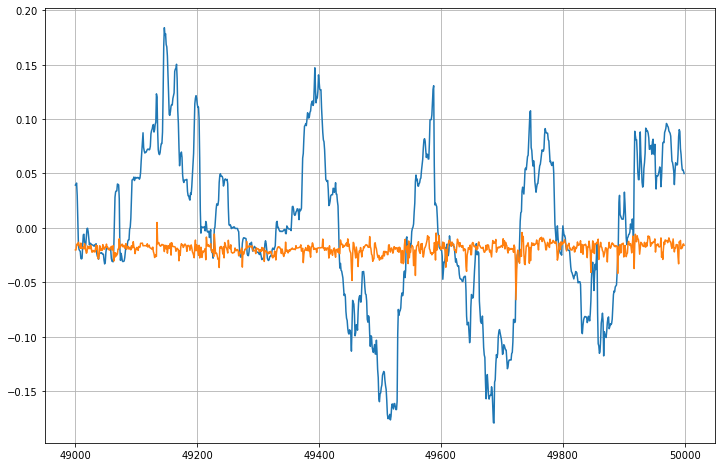

In [120]:
plt.figure(figsize=(12,8))
#plt.plot(y_train,color='red')
plt.plot(y_test[-1000:])
plt.plot(y_pred[-1000:])
plt.grid();

In [41]:
torch.save(ridge, "ridge_model.pt")

In [47]:
y_pred=pd.Series(ridge.predict(X))

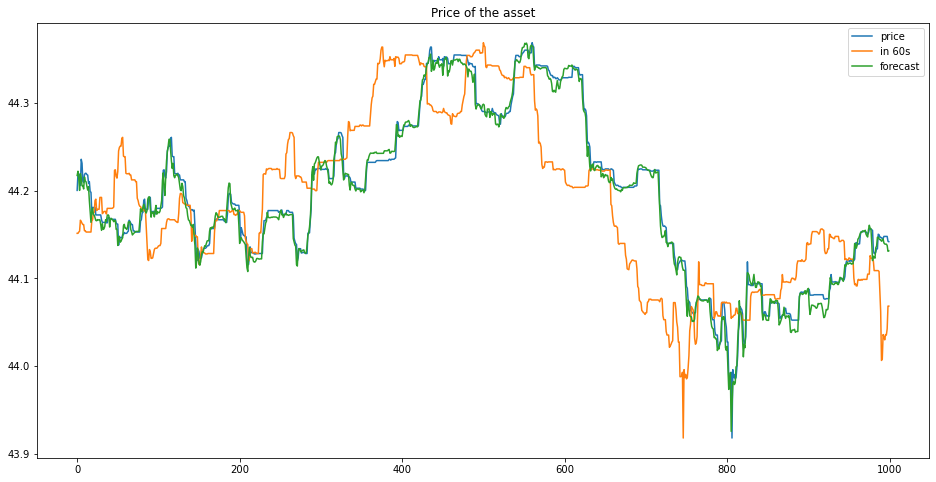

In [48]:
plt.figure(figsize=(16, 8))
plt.plot(data.price.price[:1000], label='price')
plt.plot(y[:1000], label='in 60s')
plt.plot(pd.Series(ridge_load.predict(X))[:1000], label='forecast')
plt.title('Price of the asset')
plt.legend()
plt.show()

#### Регрессия случайным лесом

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
from sklearn.model_selection import GridSearchCV

In [78]:
dtr=RandomForestRegressor(random_state=0)

In [ ]:
parameters = {
    #'n_estimators': [50,75],
    'max_depth': [1,2,3,4],
}

In [ ]:
#grid_search=GridSearchCV(dtr, parameters)

In [ ]:
#долго бежит
#grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_clf=grid_search.best_estimator_

In [79]:
dtr.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
y_pred=pd.Series(dtr.predict(X_test), index=y_test.index)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_train,color='red')
plt.plot(y_test)
plt.plot(y_pred)
plt.grid();

Результат на случайном лесе со стандартными параметрами (датасет из слэка):

In [ ]:
r2_score(y_test,y_pred)

In [ ]:
mean_squared_error(y_test,y_pred)

Результат на случайном лесе с максимальной глубиной 4:

In [ ]:
r2_score(y_test,y_pred_best)

In [ ]:
mean_squared_error(y_test,y_pred_best)